## Experiment with flight data APIs

Initial goal: compare deterministic optimal (cheapest) flight search to agent-driven one

In [1]:
from utils.utils import get_flights_to_destinations, plot_price_distribution

import nest_asyncio
nest_asyncio.apply()

import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()

from openai import AsyncOpenAI
client = AsyncOpenAI()

from IPython.display import Markdown, display

import warnings
warnings.filterwarnings("ignore")

Test query with the function

In [2]:
flights_df = get_flights_to_destinations(
    date="2025-05-02",
    from_airport="EWR",
    to_airports=[
        "ORY",  # Orly
        "CDG",  # Charles de Gaulle
    ],
    max_stops=1,
    #trip="one-way",
    #passengers_adults=2,
)

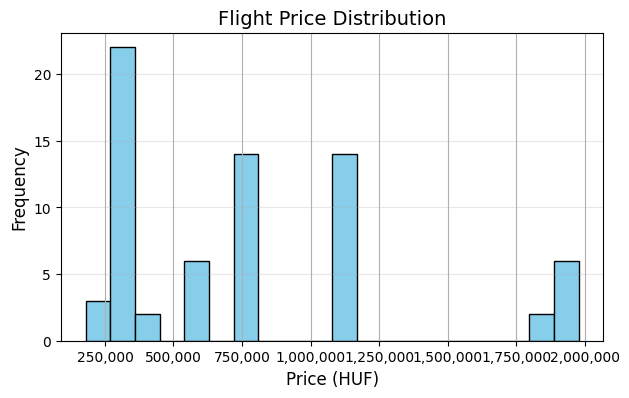

In [3]:
fig = plot_price_distribution(flights_df)

In [4]:
flights_df.head(3)

,price,departure_date,departure_time,arrival_date,arrival_time,duration_hours,name,stops,is_best,price_denomination
0,179194,2025-05-02,23:00,2025-05-03,12:15,7.250,French bee,0,True,HUF
1,408432,2025-05-02,20:25,2025-05-03,21:55,19.500,Self transferThis trip includes tickets from m...,1,True,HUF
2,601430,2025-05-02,20:20,2025-05-03,19:25,17.083,LOT,1,True,HUF


### General tool-calling agent

Showcasing tool calling capabilities by assigning the above function as a tool to an OpenAI model. Tool will return with the pandas under the hood, the AI will analyze the content and provide an answer

1. Set up custom tool

In [5]:
from agents import WebSearchTool
from utils.tools import get_flights_to_destinations_tool, add_tool
from utils.prompts import system_message, user_message_template
from utils.ai import ai, conversation

2. Set up `ai` args

In [6]:
payload = {
    "agent_name": "Flight Assistant",
    "system_message": system_message,
    "user_message_template": user_message_template,
    "tools": [get_flights_to_destinations_tool, add_tool, WebSearchTool()],
    "stream": True,
    "model": "gpt-4.1",
    "format_to_md": True
}

Simple test

In [4]:
q = 'first, tell me what 4 + 10 is using the add tool, then tell me what is the difference between declarative and imperative?'
a = await ai(q, **payload)

The result of 4 + 10 is 14.

Now, to answer your second question:
- Declarative and imperative are two major programming paradigms:
  - Declarative programming focuses on describing what you want to achieve, without specifying the exact steps to do it. Examples include SQL (for databases) and HTML (for structure of webpages). You state the desired outcome.
  - Imperative programming is about describing how to achieve a result, step by step. You explicitly tell the computer what to do and how to do it. Languages like C, Java, and Python are commonly used in this paradigm.

In short: Declarative = what, Imperative = how.

Tool add_tool called with arguments: {"a":4,"b":10}
Tool call 3j6k9Ej0bF33MU6CkJ0an3sn returned with results: 14


In [7]:
display(Markdown(a.final_output))

The result of 4 + 10 is 14.

Now, to answer your second question:
- Declarative and imperative are two major programming paradigms:
  - Declarative programming focuses on describing what you want to achieve, without specifying the exact steps to do it. Examples include SQL (for databases) and HTML (for structure of webpages). You state the desired outcome.
  - Imperative programming is about describing how to achieve a result, step by step. You explicitly tell the computer what to do and how to do it. Languages like C, Java, and Python are commonly used in this paradigm.

In short: Declarative = what, Imperative = how.

In [ ]:
q = 'first, tell me what 4 + 10 is using the add tool, then search for latest sp500 news'
a = await ai(q, **payload)

Test with flight related question

In [7]:
q = 'cheap flights budapest madrid tomorrow'
a = await ai(q, **payload)

Here are the cheapest flight options from Budapest (BUD) to Madrid (MAD) for tomorrow, April 22, 2025:

### Cheapest Direct Flights
- **Ryanair**
  - Price: 214,598 HUF
  - Departure: 20:10 | Arrival: 23:30 (3h 20m nonstop)
  - This is the best deal for a direct flight.
- **Wizz Air**
  - Price: 248,130 HUF
  - Departure: 16:00 | Arrival: 19:30 (3h 30m nonstop)
- **Iberia**
  - Price: 405,800 HUF
  - Departure: 15:30 | Arrival: 18:50 (3h 20m nonstop)

### Cheapest 1-Stop (Connecting) Flights
- **Brussels Airlines**
  - Price: 370,400 HUF
  - Departure: 06:35 | Arrival: 11:50 (5h 15m, 1 stop)
- **Self Transfer (multiple airlines)**
  - Price: 224,614 HUF
  - Departure: 13:05 | Arrival: Next day—12:10 (23h 5m, 1 stop)
  - Long layover, but can sometimes offer better flexibility.

### Price Distribution
- **Cheapest direct flight:** 214,598 HUF (Ryanair, evening).
- **Average price for direct flights:** 214,000–405,800 HUF.
- **Premium/premium economy options:** Often exceed 800,000 HUF, with business class and traditional airlines (KLM, British Airways, Lufthansa) ranging from ~838,400 HUF to over 1,250,000 HUF.

### Recommendations:
- For best value and convenience, Ryanair’s direct flight at 20:10 is recommended.
- For a slightly earlier direct flight, Wizz Air at 16:00 is another solid choice, at a modest price increase.
- If a morning departure is needed and you don’t mind one stop, Brussels Airlines at 06:35 offers a good compromise.

Would you like details on baggage, seat selection, or how to book? Let me know your preferences!

Tool get_flights_to_destinations_tool called with arguments: {"date":"2025-04-22","from_airport":"BUD","to_airports":["MAD"],"max_stops":1}
Tool call C4DNBxjLdaRtpHTQrb6fber9 returned with results:       price departure_date departure_time arrival_date arrival_time  \
0    214598     2025-04-22          20:10   2025-04-22        23:30   
1    248130     2025-04-22          16:00   2025-04-22        19:30   
2    370400     2025-04-22          0


In [8]:
display(Markdown(a.final_output))

Here are the cheapest flight options from Budapest (BUD) to Madrid (MAD) for tomorrow, April 22, 2025:

### Cheapest Direct Flights
- **Ryanair**
  - Price: 214,598 HUF
  - Departure: 20:10 | Arrival: 23:30 (3h 20m nonstop)
  - This is the best deal for a direct flight.
- **Wizz Air**
  - Price: 248,130 HUF
  - Departure: 16:00 | Arrival: 19:30 (3h 30m nonstop)
- **Iberia**
  - Price: 405,800 HUF
  - Departure: 15:30 | Arrival: 18:50 (3h 20m nonstop)

### Cheapest 1-Stop (Connecting) Flights
- **Brussels Airlines**
  - Price: 370,400 HUF
  - Departure: 06:35 | Arrival: 11:50 (5h 15m, 1 stop)
- **Self Transfer (multiple airlines)**
  - Price: 224,614 HUF
  - Departure: 13:05 | Arrival: Next day—12:10 (23h 5m, 1 stop)
  - Long layover, but can sometimes offer better flexibility.

### Price Distribution
- **Cheapest direct flight:** 214,598 HUF (Ryanair, evening).
- **Average price for direct flights:** 214,000–405,800 HUF.
- **Premium/premium economy options:** Often exceed 800,000 HUF, with business class and traditional airlines (KLM, British Airways, Lufthansa) ranging from ~838,400 HUF to over 1,250,000 HUF.

### Recommendations:
- For best value and convenience, Ryanair’s direct flight at 20:10 is recommended.
- For a slightly earlier direct flight, Wizz Air at 16:00 is another solid choice, at a modest price increase.
- If a morning departure is needed and you don’t mind one stop, Brussels Airlines at 06:35 offers a good compromise.

Would you like details on baggage, seat selection, or how to book? Let me know your preferences!

In [9]:
a.new_items

[ToolCallItem(agent=Agent(name='Flight Assistant', instructions="You are a helpful personal assistant. You are able to get real-time flight information for a given destination and date. You answer users' questions about flight prices and availability.", handoff_description=None, handoffs=[], model='gpt-4.1', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=False, truncation=None, max_tokens=None), tools=[FunctionTool(name='get_flights_to_destinations_tool', description='Fetch flights to multiple destinations and return a combined DataFrame.', params_json_schema={'properties': {'date': {'description': 'Flight date in YYYY-MM-DD format', 'title': 'Date', 'type': 'string'}, 'from_airport': {'description': 'Departure airport code in IATA format (3-letter codes), such as "BUD"', 'title': 'From Airport', 'type': 'string'}, 'to_airports': {'description': 'List of destination airport codes in IATA fo

In [10]:
a.raw_responses

[ModelResponse(output=[ResponseFunctionToolCall(id='fc_680641537f448192b303ae875ebfa60e0b8d84e233da1ea9', arguments='{"date":"2025-04-22","from_airport":"BUD","to_airports":["MAD"],"max_stops":1}', call_id='call_C4DNBxjLdaRtpHTQrb6fber9', name='get_flights_to_destinations_tool', type='function_call', status='completed')], usage=Usage(requests=1, input_tokens=674, output_tokens=45, total_tokens=719), referenceable_id='resp_6806415281f48192b3239c2bb024cfcb0b8d84e233da1ea9'),
 ModelResponse(output=[ResponseOutputMessage(id='msg_68064157f0bc81928c139a41353972070b8d84e233da1ea9', content=[ResponseOutputText(annotations=[], text='Here are the cheapest flight options from Budapest (BUD) to Madrid (MAD) for tomorrow, April 22, 2025:\n\n### Cheapest Direct Flights\n- **Ryanair**\n  - Price: 214,598 HUF\n  - Departure: 20:10 | Arrival: 23:30 (3h 20m nonstop)\n  - This is the best deal for a direct flight.\n- **Wizz Air**\n  - Price: 248,130 HUF\n  - Departure: 16:00 | Arrival: 19:30 (3h 30m nons

Complex question

In [43]:
model_for_complex_question = 'o1'

q = 'I want to find the best deal for flying to Madeira from Budapest any time between 2025-07-01 and 2025-07-15. I will want to spend at least 5, at most 8 days there. I will be traveling with my girlfriend. Ideally I only want to have at most 1 stop. Find the optimal flight for me. I want to have the cheapest flight possible.'

a = await ai(q, **payload.update({"model": model_for_complex_question}))

In [ ]:
display(Markdown(a.final_output))

In [ ]:
a.new_items

#### Implement conversation memory

In [2]:
payload = {
    "agent_name": "Flight Assistant",
    "system_message": system_message,
    "user_message_template": user_message_template,
    "tools": [get_flights_to_destinations_tool, add_tool, WebSearchTool()],
    "stream": True,
    "model": "gpt-4.1",
    "format_to_md": False
}

In [3]:
await conversation(payload)



=== Human ===
yo

=== AI ===
Hello! How can I help you today? If you’re looking for flight information, just let me know your travel details (such as cities, dates, and preferences), and I’ll find the best options for you. Or, feel free to ask me anything else!

=== Human ===
5555555-345342423

=== AI ===
It looks like you've entered "5555555-345342423." Could you clarify what this refers to or let me know how I can assist you further? If you’re looking for flight information or have another question, please give me a bit more detail so I can help you effectively!

=== Human ===
213421+3453412

=== AI ===
Tool add_tool called with arguments: {"a":213421,"b":3453412}
Tool call mO68x5iV1J9aH2zeieMj68CI returned with results: 3666833
213,421 + 3,453,412 equals 3,666,833. If you have any other questions, whether about calculations, flights, or anything else, just let me know!

=== Human ===
quit


Tracing client error 403: {
  "error": {
    "message": "Traces ingestion is not permitted for zero data retention organizations.",
    "type": "invalid_request_error",
    "param": null,
    "code": "zdr_forbidden"
  }
}
Tracing client error 403: {
  "error": {
    "message": "Traces ingestion is not permitted for zero data retention organizations.",
    "type": "invalid_request_error",
    "param": null,
    "code": "zdr_forbidden"
  }
}
Tracing client error 403: {
  "error": {
    "message": "Traces ingestion is not permitted for zero data retention organizations.",
    "type": "invalid_request_error",
    "param": null,
    "code": "zdr_forbidden"
  }
}
Tracing client error 403: {
  "error": {
    "message": "Traces ingestion is not permitted for zero data retention organizations.",
    "type": "invalid_request_error",
    "param": null,
    "code": "zdr_forbidden"
  }
}
Tracing client error 403: {
  "error": {
    "message": "Traces ingestion is not permitted for zero data retenti

### Try manual price checks

In [50]:
def find_cheapest_round_trip(
    outbound_date,
    total_travel_time_min,
    total_travel_time_max,
    outbound_date_flexibility,
    from_airport,
    to_airports,
    max_stops=1
):
    """
    Find the cheapest round trip flights based on flexible dates and travel duration.
    
    Args:
        outbound_date (str): Starting date for outbound flight in format 'YYYY-MM-DD'
        total_travel_time_min (int): Minimum number of days for the trip
        total_travel_time_max (int): Maximum number of days for the trip
        outbound_date_flexibility (int): Number of days to check after the outbound date
        from_airport (str): Departure airport code
        to_airports (list): List of destination airport codes
        max_stops (int): Maximum number of stops allowed
        
    Returns:
        tuple: (best_combination_df, all_combinations_df) where:
            - best_combination_df is a DataFrame with the cheapest round trip
            - all_combinations_df is a DataFrame with all combinations tried
    """
    
    # Convert outbound_date to datetime
    outbound_date_dt = datetime.strptime(outbound_date, "%Y-%m-%d")
    
    # Initialize results storage
    all_combinations = []
    
    # Loop through each potential outbound date with tqdm progress bar
    for outbound_offset in tqdm(range(outbound_date_flexibility + 1), desc="Checking outbound dates"):
        current_outbound_date = outbound_date_dt + timedelta(days=outbound_offset)
        current_outbound_str = current_outbound_date.strftime("%Y-%m-%d")
        
        # Get outbound flights
        outbound_flights = get_flights_to_destinations(
            date=current_outbound_str,
            from_airport=from_airport,
            to_airports=to_airports,
            max_stops=max_stops
        )
        
        if outbound_flights.empty:
            continue
            
        # Add direction indicator
        outbound_flights['direction'] = 'outbound'
        
        # Loop through each potential return date based on min/max travel time
        for travel_days in tqdm(range(total_travel_time_min, total_travel_time_max + 1), 
                               desc=f"Checking return dates for outbound {current_outbound_str}", 
                               leave=False):
            return_date = current_outbound_date + timedelta(days=travel_days)
            return_date_str = return_date.strftime("%Y-%m-%d")
            
            # Get return flights
            return_flights = get_flights_to_destinations(
                date=return_date_str,
                from_airport=to_airports[0],  # Assuming the first airport in the list is the main one
                to_airports=[from_airport],
                max_stops=max_stops
            )
            
            if return_flights.empty:
                continue
                
            # Add direction indicator
            return_flights['direction'] = 'return'
            
            # Find cheapest combination
            min_outbound_price = outbound_flights['price'].min()
            min_return_price = return_flights['price'].min()
            total_price = min_outbound_price + min_return_price
            
            # Get the cheapest outbound and return flights
            cheapest_outbound = outbound_flights.loc[outbound_flights['price'] == min_outbound_price].iloc[0]
            cheapest_return = return_flights.loc[return_flights['price'] == min_return_price].iloc[0]
            
            # Combine all flights for this date combination
            combined_flights = pd.concat([outbound_flights, return_flights])
            
            # Store the combination details
            all_combinations.append({
                'outbound_date': current_outbound_str,
                'return_date': return_date_str,
                'travel_days': travel_days,
                'total_price': total_price,
                'outbound_price': min_outbound_price,
                'return_price': min_return_price,
                'cheapest_outbound': cheapest_outbound,
                'cheapest_return': cheapest_return,
                'all_flights': combined_flights
            })
    
    # Convert to DataFrame
    if not all_combinations:
        return pd.DataFrame(), pd.DataFrame()
    
    combinations_df = pd.DataFrame([
        {
            'outbound_date': combo['outbound_date'],
            'return_date': combo['return_date'],
            'travel_days': combo['travel_days'],
            'total_price': combo['total_price'],
            'outbound_price': combo['outbound_price'],
            'return_price': combo['return_price'],
            'outbound_airline': combo['cheapest_outbound']['name'],
            'return_airline': combo['cheapest_return']['name'],
            'outbound_stops': combo['cheapest_outbound']['stops'],
            'return_stops': combo['cheapest_return']['stops'],
            'outbound_duration': combo['cheapest_outbound']['duration_hours'],
            'return_duration': combo['cheapest_return']['duration_hours'],
        }
        for combo in all_combinations
    ])
    
    # Find the cheapest overall combination
    best_combination_idx = combinations_df['total_price'].idxmin()
    best_combination = all_combinations[best_combination_idx]['all_flights']
    
    # Sort combinations by total price
    combinations_df = combinations_df.sort_values('total_price')
    
    return best_combination, combinations_df

In [ ]:
# Example usage:
best_flights, all_combinations = find_cheapest_round_trip(
    outbound_date="2025-07-10",
    total_travel_time_min=10,
    total_travel_time_max=16,
    outbound_date_flexibility=30,
    from_airport="BUD",
    to_airports=["JFK", "EWR", "LAX", "SFO"],
    max_stops=2
)

In [ ]:
all_combinations.sort_values(['total_price']).head(10)